
# re:Invent 2022 workshop AIM342: Advancing Responsible AI

# Bias in the world of colorful digits

This notebook explores unwanted bias in machine learning (ML) models. We conduct experiments on a synthetic problem that has direct parallels to real-world bias in AI: the colorful digits dataset. This dataset contains images of blue and orange handwritten digits in [0,9]. We also introduce an ML model to classify each image according to its digit, based on visual features. 

## Attributes for bias measurement

These experiments measure unwanted bias, which happens when the system performs differently for different subsets or groups within the data. In AI systems that represent people, such as face, voice, or speech recognition, we can define groups using demographics like gender, age, or race. In the world of colorful digits, we define groups of numbers. For example, in addition to their digit 0-9, our numbers can be even or odd, linear or curvy, green or red. Using these groups, we can practice the same bias measurement techniques that apply to real-world AI systems. 

## Real-world problems in an experimental setting

Although we won’t draw a 1:1 correspondence between numbers and people, we will place our colorful digits in realistic situations where bias comes with a cost. What happens to red 3’s when they pass through airport security? What happens to curvy numbers when they apply for loans? The world of colorful digits is a space to explore these costs and connect them to hands-on experiments using a single dataset that is practical and objective.

The colorful digits dataset is derived from MNIST [1] and inspired by other derivatives, such as biasedMNIST [2].

1. Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner. (1998) "Gradient-based learning applied to document recognition." Proceedings of the IEEE, 86(11):2278-2324, November 1998. Online (http://yann.lecun.com/exdb/publis/index.html#lecun-98)
2. Hyojin Bahng, Sanghyuk Chun, Sangdoo Yun, Jaegul Choo, and Seong Joon Oh. (2020) Learning de-biased representations with biased representations (http://proceedings.mlr.press/v119/bahng20a/bahng20a.pdf). In Proceedings of the 37th International Conference on Machine Learning (ICML'20). JMLR.org, Article 50, 528–539.

## Learning Objectives
In this workshop you will learn to
* Read and understand bias measurements
* Choose a bias metric
* Explore bias on intersections
* Find sources of bias
* Compare validation sets
* Address balanced/unbalanced training data

## Runtime
This module takes about 60 minutes to run.

## Contents
1. [Setup](#Setup)
1. [Data and baseline model](#Data-and-baseline-model)
1. [Measure accuracy and bias](#Measure-accuracy-and-bias)
1. [Choose a bias metric](#Choose-a-bias-metric)
1. [Explore bias on intersections](#Explore-bias-on-intersections)
1. [Find sources of bias](#Find-sources-of-bias)
    * [Compare validation sets](#Compare-validation-sets)
    * [Address balanced/unbalanced training data](#Address-balanced-unbalanced-training-data)
1. [Conclusions](#Conclusions) 

# Setup

Make sure you select the `conda_rai_kernel` in your notebook instance.

This kernel includes pytorch, numpy, pillow, matplotlib, torch, torchvision, cv2, seaborn, and pandas, which you need
for this notebook.

You may run this notebook by selecting Run->Run All Cells from the menu above. 

In [1]:
# Imports
from dataset_utils import *
from train_utils import *

%matplotlib inline

# Data and baseline model

Our dataset has two splits: training and validation. Test on held-out data (not overlapping with train or validation) before launching your model.

In [2]:
# Download and prepare the data
# Return two pandas DataFrames where each row is an image and each col is a group attribute
#
#           This takes about 15s
train_data, val_data = create_starting_data()

In [3]:
from train_utils import train_baseline_model

# Train a small neural network to perform classification on the images
#
#           This takes about 10s
base_model = train_baseline_model(df=train_data)

Train Epoch: 1 [0/46620 (0%)]	Loss: 2.310682
Train Epoch: 1 [6400/46620 (14%)]	Loss: 0.723108
Train Epoch: 1 [12800/46620 (27%)]	Loss: 0.341795
Train Epoch: 1 [19200/46620 (41%)]	Loss: 0.649870
Train Epoch: 1 [25600/46620 (55%)]	Loss: 0.389610
Train Epoch: 1 [32000/46620 (69%)]	Loss: 0.551143
Train Epoch: 1 [38400/46620 (82%)]	Loss: 0.327138
Train Epoch: 1 [44800/46620 (96%)]	Loss: 0.353474
Train Epoch: 2 [0/46620 (0%)]	Loss: 0.352636
Train Epoch: 2 [6400/46620 (14%)]	Loss: 0.379547
Train Epoch: 2 [12800/46620 (27%)]	Loss: 0.284994
Train Epoch: 2 [19200/46620 (41%)]	Loss: 0.545110
Train Epoch: 2 [25600/46620 (55%)]	Loss: 0.322743
Train Epoch: 2 [32000/46620 (69%)]	Loss: 0.514396
Train Epoch: 2 [38400/46620 (82%)]	Loss: 0.242651
Train Epoch: 2 [44800/46620 (96%)]	Loss: 0.200906
Train Epoch: 3 [0/46620 (0%)]	Loss: 0.371860
Train Epoch: 3 [6400/46620 (14%)]	Loss: 0.473972
Train Epoch: 3 [12800/46620 (27%)]	Loss: 0.272425
Train Epoch: 3 [19200/46620 (41%)]	Loss: 0.323789
Train Epoch: 3 [25

# Measure accuracy and bias

Run the trained model using val_data set as input and save the model predictions.

In [5]:
from eval_utils import run_baseline_model

# Run the trained model on our validation set
results_df = run_baseline_model(base_model, val_data)

# The results have a new column 'pred1' for model predictions
print(results_df[['digit','parity','curve','magnitude','color','pred1']][:5])

  digit parity    curve magnitude   color  pred1
0     7    odd    lines     large  orange      7
1     2   even  neutral     small    blue      2
2     1    odd    lines     small    blue      1
3     0   even  neutral     small    blue      0
4     4   even    lines    medium    blue      4


Accuracy is a function of how often the model predictions ('pred1' column) match ground truth ('label' column). 

In [6]:
from eval_utils import compute_accuracy

# Compute accuracy on the full validation set
acc = compute_accuracy(results_df, 'label', 'pred1')
print('Accuracy: ', acc)

Accuracy:  0.89


In the [Introduction](#bias-in-the-world-of-colorful-digits), we described groups of numbers: evens and odds, blues and oranges, etc. 

Next, we break down accuracy according to these groups.

## Group attributes for bias measurement

Attributes of colorful digits: 
* digit = {'0', '1', '2', '3', '4', '5', '6', '7', '8', '9'}
* magnitude = {small, medium, big}
* parity = {even, odd}
* curve = {curves, lines, neutral}
* color = {red, green}.

We define our groups with these attributes. For example, "all images where parity==even" is a group.

## Bias by digit, color, and curve

### Digit

In [7]:
from eval_utils import print_accuracy_by_group

# Accuracy broken down by digit
print_accuracy_by_group(results_df, group_col='digit', prediction_col='pred1', ground_truth_col='label')

Accuracy on images with digit 0: 0.95
Accuracy on images with digit 1: 0.97
Accuracy on images with digit 2: 0.89
Accuracy on images with digit 3: 0.72
Accuracy on images with digit 4: 0.93
Accuracy on images with digit 5: 0.79
Accuracy on images with digit 6: 0.89
Accuracy on images with digit 7: 0.93
Accuracy on images with digit 8: 0.92
Accuracy on images with digit 9: 0.87


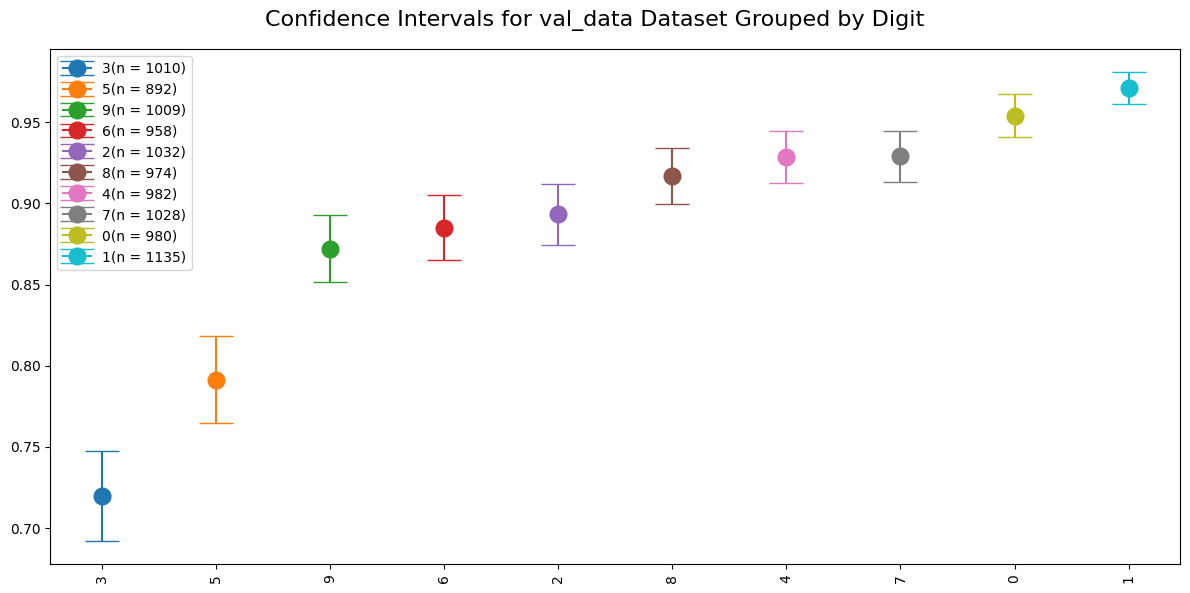

In [8]:
from plotting import plot_confidence_intervals_from_df

# Plot accuracy broken down by digit identity
plot_confidence_intervals_from_df(df_with_preds=results_df,
                                  label_col='label',
                                  pred_col='pred1',
                                  dataset_name='val_data',
                                  group_name='digit')

### Color

In [9]:
# Print out accuracy broken down by color
print_accuracy_by_group(results_df, group_col='color', prediction_col='pred1', ground_truth_col='label')

Accuracy on images with color blue: 0.89
Accuracy on images with color orange: 0.88


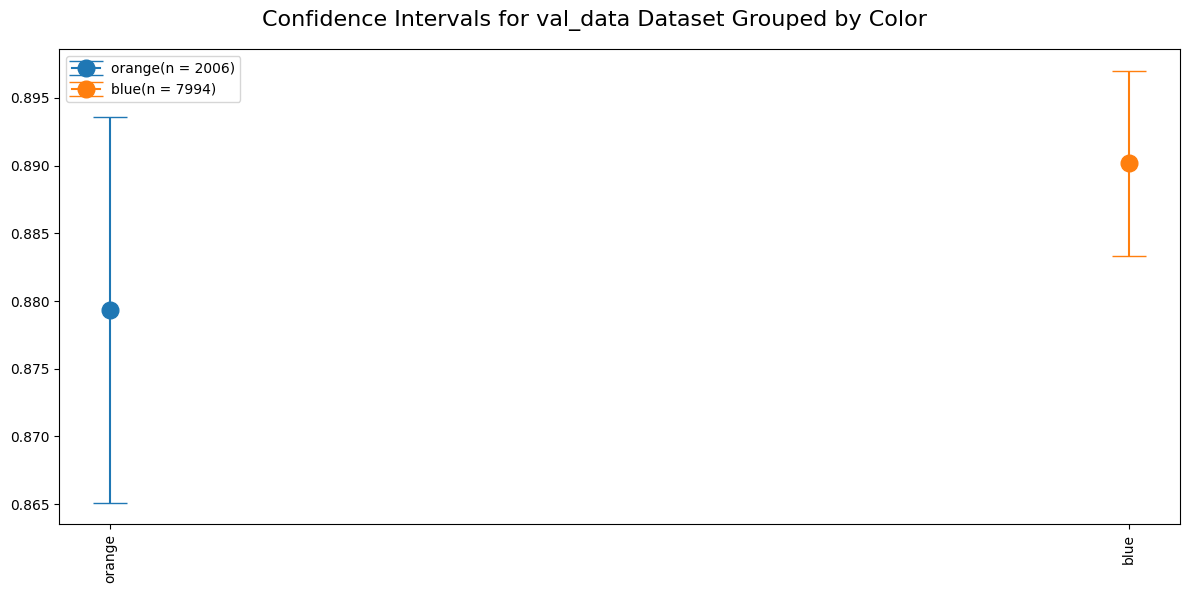

In [10]:
# Plot accuracy broken down by color
plot_confidence_intervals_from_df(df_with_preds=results_df,
                                  label_col='label',
                                  pred_col='pred1',
                                  dataset_name='val_data',
                                  group_name='color')

### Curve

In [11]:
# Print accuracy broken down by curve
print_accuracy_by_group(results_df, group_col='curve', prediction_col='pred1', ground_truth_col='label')

Accuracy on images with curve curves: 0.82
Accuracy on images with curve lines: 0.94
Accuracy on images with curve neutral: 0.88


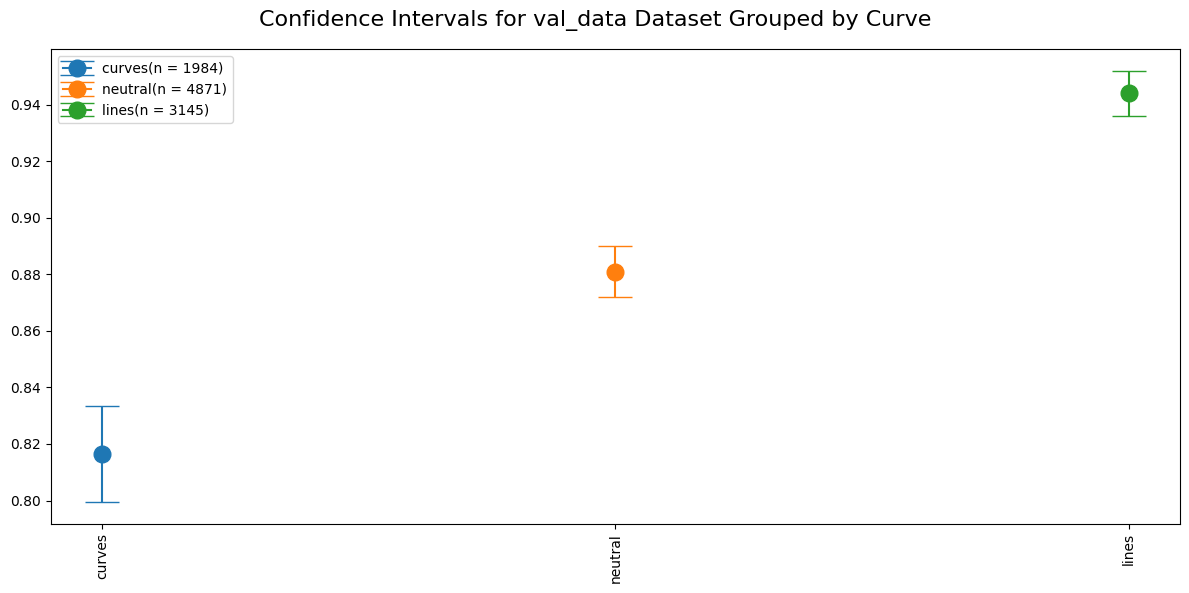

In [12]:
# Plot accuracy broken down by curve
plot_confidence_intervals_from_df(df_with_preds=results_df,
                                  label_col='label',
                                  pred_col='pred1',
                                  dataset_name='val_data',
                                  group_name='curve')

While overall accuracy is pretty good (88%), breaking out accuracy by groups reveals differences.

* Digits: 97% (best group) vs 72% (worst group)
* Colors: 89% (best group) vs 88% (worst group)
* Curve: 94% (best group) vs 82% (worst group)

## Choose a bias metric

### Use multiple metrics to find meaningful differences
Groups that look close using one metric can show large differences in another.

Use accuracy and error to understand the impact of disparities.

In [13]:
from eval_utils import get_group_accuracy_by_value

# Accuracy
accuracy = get_group_accuracy_by_value(results_df, group_col='digit', prediction_col='pred1', 
                                       ground_truth_col='label')
print(f'fours accuracy = {accuracy["4"]}, nines accuracy = {accuracy["9"]}')

# Error = 1 - Accuracy
fours_error = round(1 - accuracy['4'], 2)
nines_error = round(1 - accuracy['9'], 2)
print(f'fours error = {fours_error}, nines error = {nines_error}')

fours accuracy = 0.93, nines accuracy = 0.87
fours error = 0.07, nines error = 0.13


### Relative and absolute error disparity

In [14]:
# Absolute error disparity
absolute_errror_disparity = nines_error - fours_error
print(f'absolute error disparity = {absolute_errror_disparity}')

# Relative error on 4 vs 9
relative_error_disparity = round((nines_error - fours_error) / fours_error, 2)
print(f'relative error disparity = {relative_error_disparity}')

absolute error disparity = 0.06
relative error disparity = 0.86


9’s experience error that is only 6 points higher in absolute terms, but as a ratio this translates to an 86% increase in errors. 

If the colorful digits have to be classified before passing through airport security, this means that 9's get stopped for a pat-down 86% more often than 4's. 

In [15]:
from eval_utils import print_absolute_vs_relative

# Here are some examples that explore absolute and relative error
print_absolute_vs_relative(results_df, 'curve', 'curves', 'lines')
print_absolute_vs_relative(results_df, 'digit', '3', '0')
print_absolute_vs_relative(results_df, 'color', 'blue', 'orange')

# Try your own groups here: 4 vs 9, big vs small



error on curves = 0.18
error on lines = 0.06
absolute error disparity of 12.0 points is 200.0 percent more errors.
error on 3 = 0.28
error on 0 = 0.05
absolute error disparity of 23.0 points is 460.0 percent more errors.
error on blue = 0.11
error on orange = 0.12
absolute error disparity of 1.0 points is 9.09 percent more errors.


### Burden of errors

We can also explore the burden of errors. Of all the numbers getting sent for an extra pat-down, how many of them are 9's?

<AxesSubplot:xlabel='Digit', ylabel='Count'>

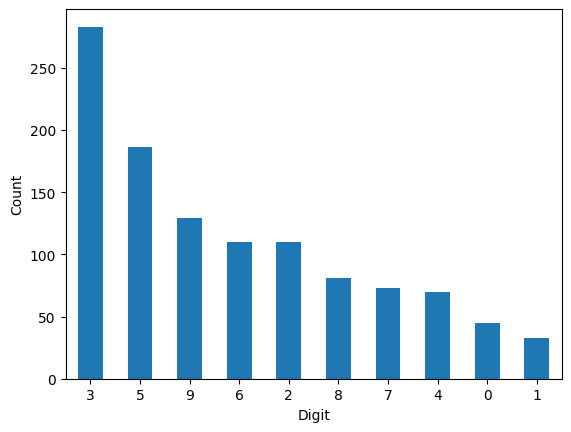

In [16]:
# Select the rows with errors and plot a histogram of the digits 
error_rows = results_df[(results_df['label']!=results_df['pred1'])]
error_rows.digit.value_counts().plot(kind='bar', xlabel='Digit', ylabel="Count", rot=0)

3's, 5's, and 9's are over-represented among the errors.

### Connect your metrics to harms and costs

We explored false rejections: 9 tries to pass through the gate, but isn’t recognized and gets sent for a pat-down. False alarms happen when other numbers get recognized as 9. 

In [17]:
from eval_utils import print_false_alarms_vs_rejects

# print out false rejections vs false alarms for a number in [0-9]
print_false_alarms_vs_rejects(results_df, 9)
print_false_alarms_vs_rejects(results_df, 0)
print_false_alarms_vs_rejects(results_df, 4)


# try a few groups on your own


false alarms on 9 = 87, false rejects on 9 = 129
false alarms on 0 = 75, false rejects on 0 = 45
false alarms on 4 = 114, false rejects on 4 = 70


Consider the cost of false alarms and false rejections in these cases:

* ID validation for airport screening
* breast cancer detection from medical imaging 
* luggage screening for dangerous contents
* accept/reject for college admissions
* accept/reject for mortgage applications

# Explore bias on intersections

What happens when we consider more than one attribute of each number?

In [18]:
from eval_utils import print_accuracy_by_intersection

# Print out the accuracy on images by digit-color intersections
#
print_accuracy_by_intersection(results_df, group1_col='digit', group2_col='color', prediction_col='pred1', ground_truth_col='label')

Accuracy on images with digit-color values 0-blue: 0.96
Accuracy on images with digit-color values 0-orange: 0.92
Accuracy on images with digit-color values 1-blue: 0.97
Accuracy on images with digit-color values 1-orange: 0.96
Accuracy on images with digit-color values 2-blue: 0.9
Accuracy on images with digit-color values 2-orange: 0.86
Accuracy on images with digit-color values 3-blue: 0.7
Accuracy on images with digit-color values 3-orange: 0.82
Accuracy on images with digit-color values 4-blue: 0.93
Accuracy on images with digit-color values 4-orange: 0.92
Accuracy on images with digit-color values 5-blue: 0.79
Accuracy on images with digit-color values 5-orange: 0.81
Accuracy on images with digit-color values 6-blue: 0.88
Accuracy on images with digit-color values 6-orange: 0.89
Accuracy on images with digit-color values 7-blue: 0.93
Accuracy on images with digit-color values 7-orange: 0.92
Accuracy on images with digit-color values 8-blue: 0.93
Accuracy on images with digit-colo

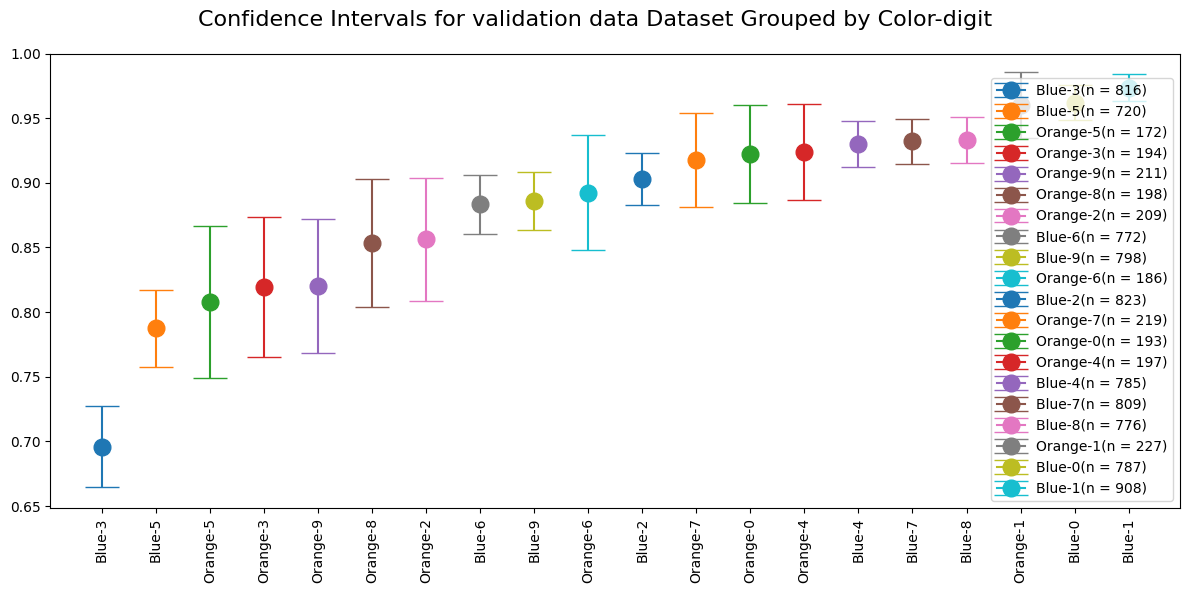

In [19]:
from plotting import plot_intersectional_confidence_intervals_from_df


# Plot accuracy on images by digit-color intersections
#
plot_intersectional_confidence_intervals_from_df(results_df, label_col='label', pred_col='pred1', 
                                                 dataset_name='validation data', group_1='color', group_2='digit')


### Compounding disparity

Oranges get similar accuracy to blues (88% vs 89%).

Eights get above-average accuracy (91% vs 89%).

However orange eights get lower accuracy than the average (85% vs 89%), and much lower accuracy than blue eights (85% vs 93%).

# Find sources of bias

Results vary based on validation set in addition to the training data, model architecture, and learned parameters.

## Compare validation sets

In [20]:
from dataset_utils import get_val2

# Pull up a second validation set
val_2_data = get_val2(val_data)

# Run the same baseline model on this second validation set and gather results
results_2_df = run_baseline_model(base_model, val_2_data)

In [21]:
# Bias results on val_data
print_accuracy_by_group(results_df, group_col='digit', prediction_col='pred1', ground_truth_col='label')

Accuracy on images with digit 0: 0.95
Accuracy on images with digit 1: 0.97
Accuracy on images with digit 2: 0.89
Accuracy on images with digit 3: 0.72
Accuracy on images with digit 4: 0.93
Accuracy on images with digit 5: 0.79
Accuracy on images with digit 6: 0.89
Accuracy on images with digit 7: 0.93
Accuracy on images with digit 8: 0.92
Accuracy on images with digit 9: 0.87


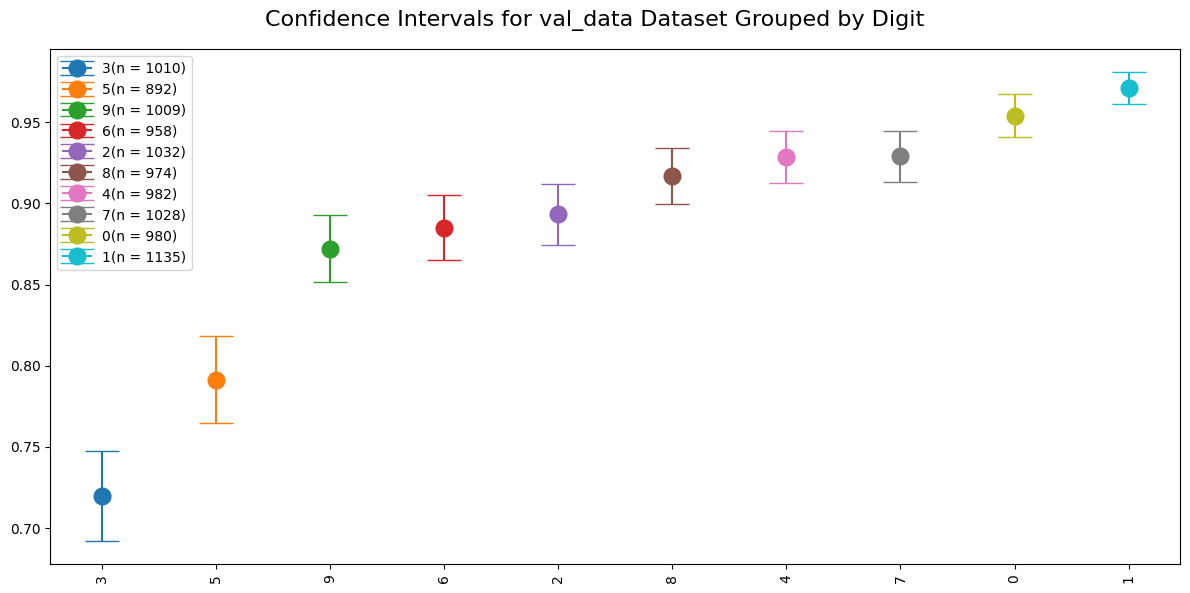

In [22]:
# Plot accuracy broken down by digit
plot_confidence_intervals_from_df(results_df, 'label', 'pred1', 'val_data', 'digit')

In [23]:
# Bias results on val_2_data
print_accuracy_by_group(results_2_df, group_col='digit', prediction_col='pred1', ground_truth_col='label')

Accuracy on images with digit 0: 0.95
Accuracy on images with digit 1: 0.97
Accuracy on images with digit 2: 0.89
Accuracy on images with digit 3: 0.72
Accuracy on images with digit 4: 0.6
Accuracy on images with digit 5: 0.79
Accuracy on images with digit 6: 0.89
Accuracy on images with digit 7: 0.93
Accuracy on images with digit 8: 0.92
Accuracy on images with digit 9: 0.87


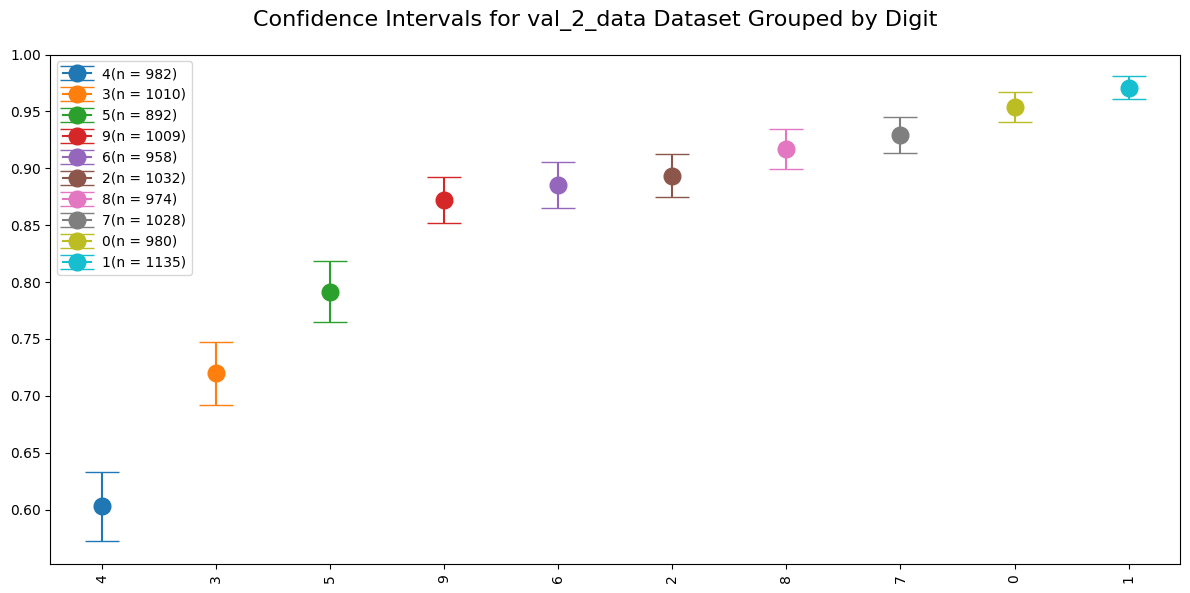

In [24]:
# Plot accuracy broken down by digit
plot_confidence_intervals_from_df(results_2_df, 'label', 'pred1', 'val_2_data', 'digit')

### Same model, different validation data 

Bias is not a feature of the model alone.

The same baseline model gives different bias results when using these two validation sets.

View some samples from each dataset.

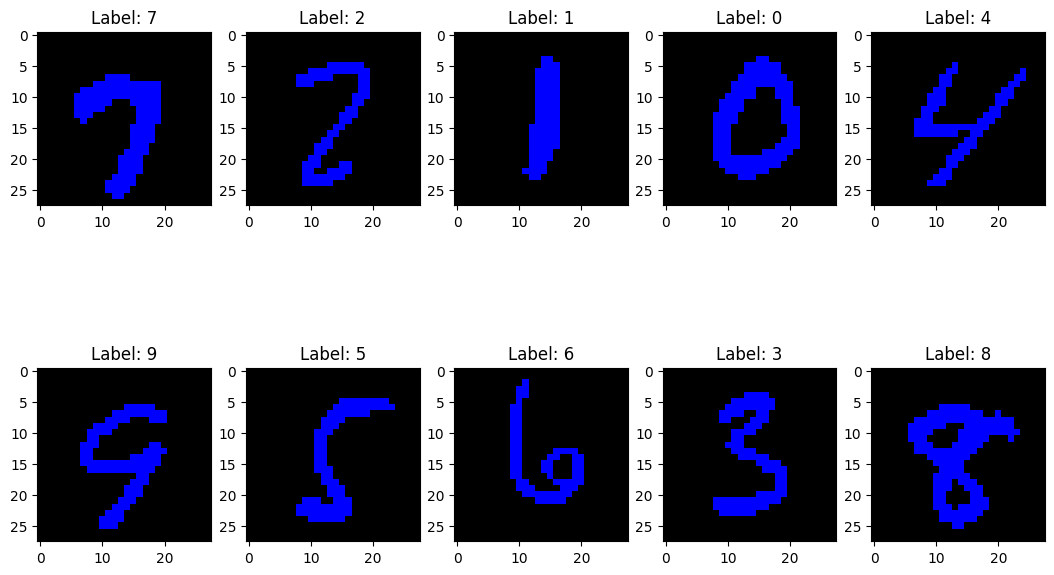

In [25]:
from plotting import plot_one_each

# View an example from each digit group in the original validation set
#
# This method selects examples at random from the dataset.
# Run the cell multiple times to view different examples.
plot_one_each(val_data)

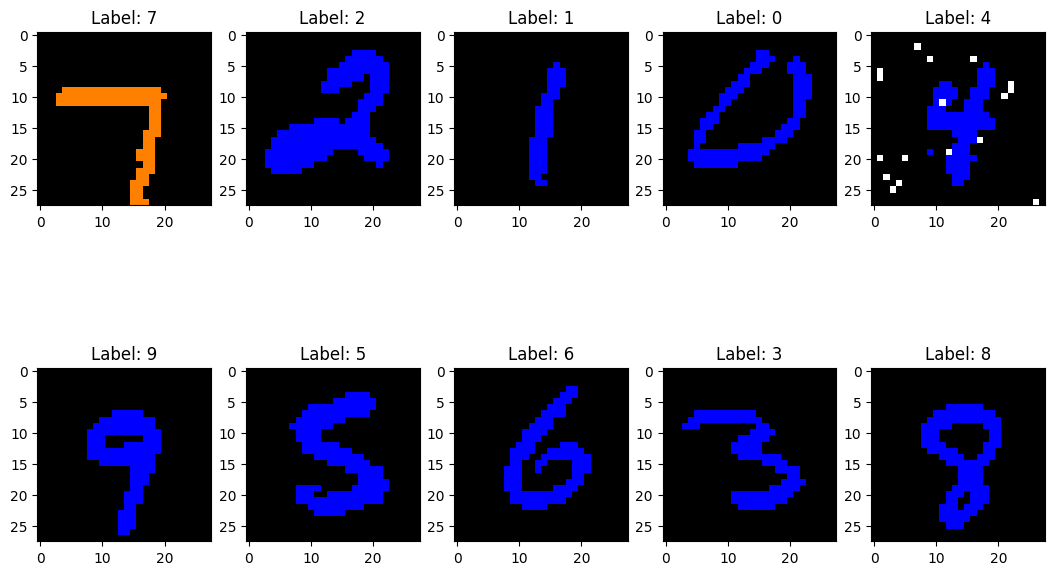

In [26]:
# View an example from each digit group in the second validation set
plot_one_each(val_2_data)

# Address balanced/unbalanced training data

Collecting more training data is a simple mitigation strategy.

In [27]:
from dataset_utils import create_augmented_data

# create second training dataset: this takes about 12s
augmented_train_data = create_augmented_data()

In [28]:
# train the same model architecture on the new data: this takes about 10s
augmented_model = train_baseline_model(df=augmented_train_data)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.329839
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.819941
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.406751
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.373797
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.529690
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.412619
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.403262
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.395622
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.544786
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.305119
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.301752
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.542627
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.331361
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.525400
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.345926
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.438897
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.227005
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.341204
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.346179
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.161182
Train Epoch:

In [29]:
# Run the augmented model on the original val_data
results_aug_df = run_baseline_model(augmented_model, val_data)

### Same validation data, different model

Overall accuracy on original training + eval = 0.89


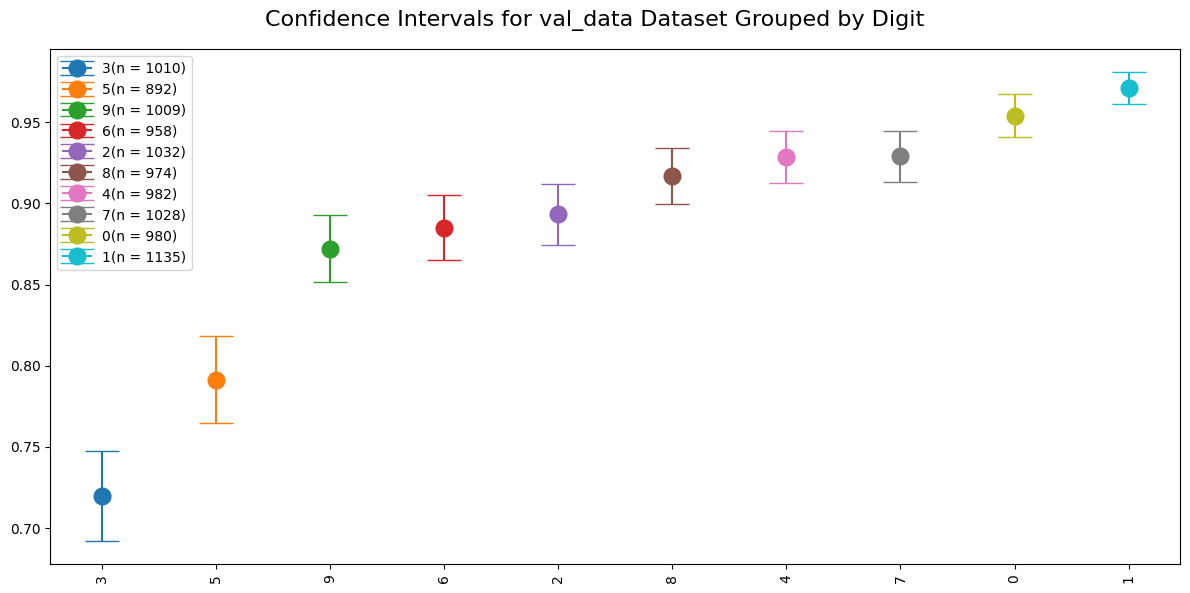

In [30]:
# Original training data
acc = compute_accuracy(results_df, 'label', 'pred1')
print(f'Overall accuracy on original training + eval = {acc}')
plot_confidence_intervals_from_df(results_df, 'label', 'pred1', 'val_data', 'digit')

Overall accuracy on original training + eval = 0.91


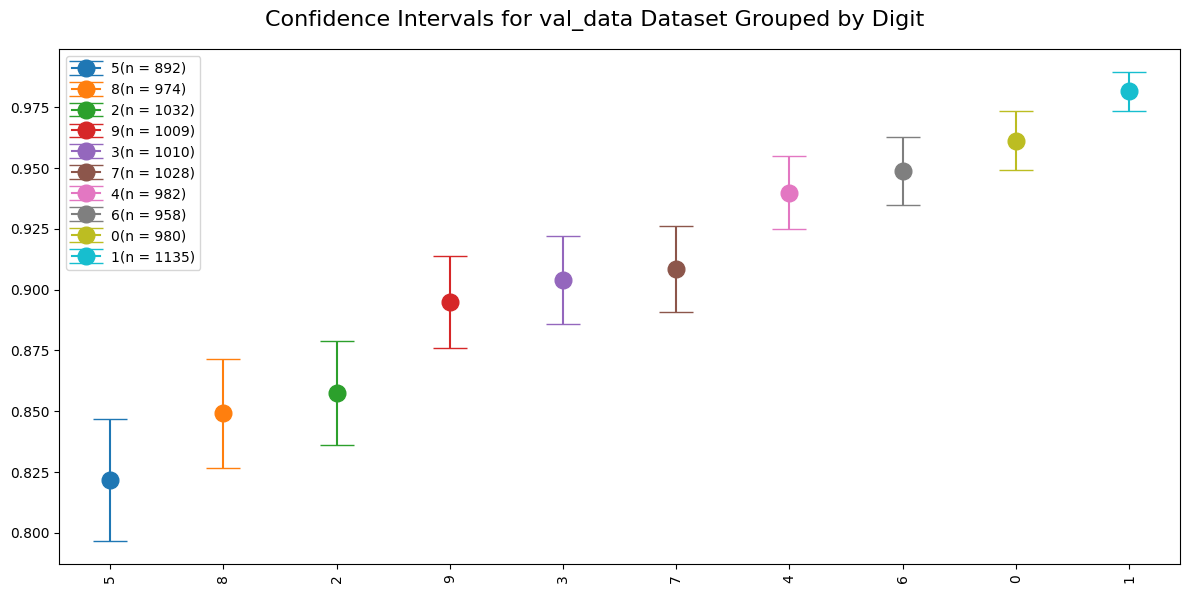

In [31]:

# Augmented training data
acc = compute_accuracy(results_aug_df, 'label', 'pred1')
print(f'Overall accuracy on original training + eval = {acc}')
plot_confidence_intervals_from_df(results_aug_df, 'label', 'pred1', 'val_data', 'digit')

## Conslusions

In this workshop we practiced skills required to generate and interpret a bias report, including: 
* Read and understand bias measurements
* Choose a bias metric
* Explore bias on intersections
* Find sources of bias
* Compare validation sets
* Address balanced/unbalanced training data


This notebook is available online at https://github.com/aws-samples/reinvent2022-advancing-responsible-ai
